# LoRA Fine-Tuning for CLIP

This notebook fine-tunes CLIP using **LoRA** (Low-Rank Adaptation) on the food recipe dataset.

**Hypothesis H1:** The fine-tuned model improves text↔image alignment compared to the CLIP baseline, measured with retrieval metrics (R@K, MRR).

**This notebook (M1 LoRA):**
- Loads pre-trained CLIP model (no quantization)
- Applies LoRA adapters to trainable modules
- Fine-tunes on training set using CLIP contrastive loss (only positive pairs, in-batch negatives)
- Evaluates on test set with **same protocol as baseline** (by recipe_id)
- Saves adapters, logs, and results for comparison

**Inputs:**
- `fine-tuning-zone/datasets/train_pairs_augmented_with_negatives.csv` (for training, filtered to label==1)
- `fine-tuning-zone/datasets/test_pairs_positive.csv` (for evaluation)
- `fine-tuning-zone/images/` and `fine-tuning-zone/augmented_images/` (images)

**Outputs:**
- `fine-tuning-zone/experiments/lora/run_{run_id}/` — Complete run directory with:
  - `config.yaml` — Training configuration
  - `adapters/` — LoRA adapter weights
  - `training_logs.json` — Loss and timing logs
  - `results_lora.json` — Evaluation metrics
  - `examples_top5.json` — Qualitative examples


## 1. Setup and Configuration


In [7]:
import os
import io
import json
import time
import math
import torch
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import torch.nn.functional as F
from PIL import Image
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError
from dotenv import load_dotenv
from tqdm import tqdm
import yaml

# CLIP and LoRA imports
TRANSFORMERS_AVAILABLE = False
PEFT_AVAILABLE = False

try:
    from transformers import CLIPModel, CLIPProcessor
    TRANSFORMERS_AVAILABLE = True
    print("✓ transformers imported successfully")
except ImportError as e:
    print(f"✗ Failed to import transformers: {e}")

try:
    from peft import LoraConfig, get_peft_model, TaskType
    PEFT_AVAILABLE = True
    print("✓ peft imported successfully")
except ImportError as e:
    print(f"✗ Failed to import peft: {e}")
    TaskType = None

# Load environment variables
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent

ENV_PATHS = [
    PROJECT_ROOT / "notebooks" / ".env",
    PROJECT_ROOT / "app" / ".env",
    PROJECT_ROOT / ".env",
]

env_loaded = False
for env_path in ENV_PATHS:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✓ Loaded .env from: {env_path}")
        env_loaded = True
        break

if not env_loaded:
    print("⚠ No .env file found, trying default load_dotenv()...")
    load_dotenv()

# Load experiment configuration (must be loaded before using CONFIG)
CONFIG_PATH = NOTEBOOK_DIR / "experiment_config.yaml"
if not CONFIG_PATH.exists():
    raise FileNotFoundError(f"Config file not found: {CONFIG_PATH}")

with open(CONFIG_PATH, 'r') as f:
    CONFIG = yaml.safe_load(f)

# MinIO Configuration (from environment)
MINIO_USER = os.getenv("MINIO_USER")
MINIO_PASSWORD = os.getenv("MINIO_PASSWORD")
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT")

# MinIO configuration (from config)
FINE_TUNING_BUCKET = CONFIG["minio"]["bucket"]
DATASETS_PREFIX = CONFIG["minio"]["prefixes"]["datasets"]
IMAGES_PREFIX = CONFIG["minio"]["prefixes"]["images"]
EXPERIMENTS_PREFIX = CONFIG["minio"]["prefixes"]["experiments"]

# Model configuration (from config)
MODEL_NAME = CONFIG["model"]["name"]

# Device selection (robust - test if CUDA actually works)
def pick_device():
    """Pick device, testing if CUDA actually works (not just available)."""
    device_config = CONFIG["model"].get("device")
    if device_config:
        # If config specifies device, test it if it's CUDA
        if device_config == "cuda":
            if not torch.cuda.is_available():
                print("⚠ Config specifies 'cuda' but CUDA is not available. Using CPU.")
                return "cpu"
            try:
                _ = torch.randn(1, device="cuda")
                return "cuda"
            except Exception as e:
                print(f"⚠ Config specifies 'cuda' but CUDA is not usable: {e}. Using CPU.")
                return "cpu"
        return device_config
    
    # Auto-detect: test if CUDA actually works
    if not torch.cuda.is_available():
        return "cpu"
    try:
        _ = torch.randn(1, device="cuda")
        return "cuda"
    except Exception as e:
        print(f"⚠ CUDA visible pero no usable: {e}")
        return "cpu"

DEVICE = pick_device()
BATCH_SIZE = CONFIG["model"]["batch_size"]

# LoRA configuration (from config)
# Ensure numeric values are properly typed
LORA_CONFIG = {
    "r": int(CONFIG["lora"]["r"]),
    "lora_alpha": int(CONFIG["lora"]["lora_alpha"]),
    "lora_dropout": float(CONFIG["lora"]["lora_dropout"]),
    "bias": CONFIG["lora"]["bias"],
    "task_type": TaskType.FEATURE_EXTRACTION if TaskType else None,  # Use enum or omit
    "target_modules": CONFIG["lora"]["target_modules"],  # Only attention modules
}

# Training configuration (from config)
# Convert learning_rate to float (YAML may read 1e-4 as string)
learning_rate = CONFIG["training"]["learning_rate"]
if isinstance(learning_rate, str):
    # Handle scientific notation strings like "1e-4"
    learning_rate = float(learning_rate)

TRAINING_CONFIG = {
    "learning_rate": learning_rate,
    "num_epochs": int(CONFIG["training"]["num_epochs"]),
    "batch_size": int(CONFIG["training"]["batch_size"]),
    "gradient_accumulation_steps": int(CONFIG["training"]["gradient_accumulation_steps"]),
    "warmup_steps": int(CONFIG["training"]["warmup_steps"]),
    "logging_steps": int(CONFIG["training"]["logging_steps"]),
    "save_steps": int(CONFIG["training"]["save_steps"]),
}

# LoRA training configuration (from config)
LORA_SCOPE = CONFIG["lora"]["scope"]   # "vision" | "text" | "both"
TRAIN_ONLY_LORA = CONFIG["lora"]["train_only_lora"]
TRAIN_LOGIT_SCALE = CONFIG["lora"]["train_logit_scale"]

# Logit scale clamping constants (CLIP best practice)
LOGIT_SCALE_MIN = math.log(1/100)  # Minimum temperature: 0.01
LOGIT_SCALE_MAX = math.log(100)     # Maximum temperature: 100

# Evaluation configuration (from config)
K_VALUES = CONFIG["evaluation"]["k_values"]
COMPUTE_MRR = CONFIG["evaluation"]["compute_mrr"]
COMPUTE_MEDIAN_RANK = CONFIG["evaluation"].get("compute_median_rank", True)

# Experiment configuration (from config)
METHOD = CONFIG["experiment"]["method"]
RESULTS_DIR_BASE = CONFIG["experiment"]["results_dir"]

# Run configuration
RUN_ID = f"{METHOD}_{datetime.now(timezone.utc).strftime('%Y%m%d_%H%M%S')}"
RUN_DIR = f"{RESULTS_DIR_BASE}/{METHOD}/run_{RUN_ID}"

# Input/Output paths (from config)
TRAIN_AUGMENTED_KEY = CONFIG["dataset"]["train_manifest_key"]
TEST_MANIFEST_KEY = CONFIG["dataset"]["test_manifest_key"]

CONFIG_KEY = f"{RUN_DIR}/config.yaml"
ADAPTERS_DIR = f"{RUN_DIR}/adapters"
LOGS_KEY = f"{RUN_DIR}/training_logs.json"
RESULTS_KEY = f"{RUN_DIR}/results_{METHOD}.json"
EXAMPLES_KEY = f"{RUN_DIR}/examples_top5.json"

# Update config to include dataset info
TRAINING_CONFIG["train_dataset"] = TRAIN_AUGMENTED_KEY
TRAINING_CONFIG["test_dataset"] = TEST_MANIFEST_KEY
TRAINING_CONFIG["filter_applied"] = "label == 1 (positive pairs only)"

print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {DEVICE}")
print(f"  Method: LoRA")
print(f"  LoRA r: {LORA_CONFIG['r']}, alpha: {LORA_CONFIG['lora_alpha']}")
print(f"  Training: {TRAINING_CONFIG['num_epochs']} epochs, LR={TRAINING_CONFIG['learning_rate']}")
print(f"  Batch size: {TRAINING_CONFIG['batch_size']} (effective: {TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']})")
print(f"  Run ID: {RUN_ID}")


✓ transformers imported successfully
✓ peft imported successfully
✓ Loaded .env from: /Users/dcayuela/Desktop/UPC/ADSDB/ADSDB_Project_Team1_2nd_delivery/adsdb-multimodal-food-data-management/notebooks/.env
Configuration:
  Model: openai/clip-vit-base-patch32
  Device: cpu
  Method: LoRA
  LoRA r: 8, alpha: 16
  Training: 3 epochs, LR=0.0001
  Batch size: 2 (effective: 32)
  Run ID: baseline_20260103_190607


## 2. Initialize MinIO Client


In [8]:
# Initialize S3/MinIO client
session = boto3.session.Session(
    aws_access_key_id=MINIO_USER,
    aws_secret_access_key=MINIO_PASSWORD,
    region_name="us-east-1"
)
s3 = session.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    config=Config(signature_version="s3v4", s3={"addressing_style": "path"})
)

def ensure_bucket_exists(bucket: str) -> bool:
    """Create bucket if it doesn't exist."""
    try:
        s3.head_bucket(Bucket=bucket)
        return True
    except ClientError as e:
        error_code = e.response.get("Error", {}).get("Code", "")
        if error_code in ("404", "NoSuchBucket"):
            try:
                s3.create_bucket(Bucket=bucket)
                print(f"✓ Created bucket '{bucket}'")
                return True
            except ClientError as create_error:
                print(f"✗ Failed to create bucket '{bucket}': {create_error}")
                return False
        return False

# Verify buckets
print("Checking buckets...")
ensure_bucket_exists(FINE_TUNING_BUCKET)
print("✓ Buckets ready")


Checking buckets...
✓ Buckets ready


## 3. Load Training and Test Datasets


In [9]:
# Load training dataset
print("Loading training dataset...")
train_obj = s3.get_object(Bucket=FINE_TUNING_BUCKET, Key=TRAIN_AUGMENTED_KEY)
train_full_df = pd.read_csv(io.BytesIO(train_obj["Body"].read()))

# Filter to positive pairs only (label == 1)
if "label" in train_full_df.columns:
    train_df = train_full_df[train_full_df["label"] == 1].copy()
    print(f"✓ Loaded {len(train_df)} positive pairs")
    print(f"  Removed {len(train_full_df) - len(train_df)} negative pairs")
else:
    train_df = train_full_df.copy()
    print(f"\n✓ No label column found, using all {len(train_df)} pairs as positive")

# Load test dataset (from baseline split, already filtered)
print("\nLoading test dataset...")
test_obj = s3.get_object(Bucket=FINE_TUNING_BUCKET, Key=TEST_MANIFEST_KEY)
test_df = pd.read_csv(io.BytesIO(test_obj["Body"].read()))
print(f"✓ Loaded {len(test_df)} test pairs")
print(f"  Recipes: {test_df['recipe_id'].nunique()}")
print(f"  Images: {test_df['image_key'].nunique()}")
print(f"  Captions: {test_df['caption'].nunique()}")


Loading training dataset...
✓ Loaded 1488 positive pairs
  Removed 372 negative pairs

Loading test dataset...
✓ Loaded 89 test pairs
  Recipes: 54
  Images: 89
  Captions: 54


## 4. Helper Functions for Image Loading


In [10]:
def load_image_from_minio(bucket: str, key: str) -> Optional[Image.Image]:
    """Load an image from MinIO."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        img = Image.open(io.BytesIO(obj["Body"].read()))
        img.load()
        return img.convert("RGB")
    except Exception as e:
        return None

# Cache for image paths to avoid head_object per sample (performance optimization)
_image_path_cache: Dict[str, Tuple[str, str]] = {}

def build_image_path_cache(df: pd.DataFrame) -> Dict[str, Tuple[str, str]]:
    """
    Pre-build cache of image_key -> (bucket, full_key) to avoid head_object calls during training.
    This significantly improves throughput when loading images from MinIO.
    """
    print("Building image path cache...")
    cache = {}
    bucket = FINE_TUNING_BUCKET
    unique_keys = df["image_key"].unique()
    
    for image_key in tqdm(unique_keys, desc="Caching image paths"):
        # Check if it's already a full path
        if image_key.startswith("images/") or image_key.startswith("augmented_images/"):
            cache[image_key] = (bucket, image_key)
        else:
            # Try images/ first
            key = f"{IMAGES_PREFIX}/{image_key}"
            # Check if exists, if not try augmented_images/
            try:
                s3.head_object(Bucket=bucket, Key=key)
                cache[image_key] = (bucket, key)
            except ClientError as e:
                if e.response.get("Error", {}).get("Code") == "404":
                    # Try augmented_images/
                    key = f"augmented_images/{image_key}"
                    cache[image_key] = (bucket, key)
                else:
                    raise
    
    print(f"✓ Cached {len(cache)} image paths")
    return cache

def get_image_path_in_minio(image_key: str) -> Tuple[str, str]:
    """
    Determine bucket and full key for an image (uses cache if available).
    
    Images can be in:
    - fine-tuning-zone/images/...
    - fine-tuning-zone/augmented_images/...
    
    If cache is built, uses it. Otherwise falls back to head_object (slower).
    """
    # Use cache if available
    if image_key in _image_path_cache:
        return _image_path_cache[image_key]
    
    # Fallback: check if it's already a full path
    bucket = FINE_TUNING_BUCKET
    if image_key.startswith("images/") or image_key.startswith("augmented_images/"):
        key = image_key
    else:
        # Try images/ first
        key = f"{IMAGES_PREFIX}/{image_key}"
        # Check if exists, if not try augmented_images/
        try:
            s3.head_object(Bucket=bucket, Key=key)
        except ClientError as e:
            if e.response.get("Error", {}).get("Code") == "404":
                # Try augmented_images/
                key = f"augmented_images/{image_key}"
            else:
                raise
    
    return bucket, key


## 5. Create Dataset and DataLoader


In [11]:
from torch.utils.data import Dataset, DataLoader
import random

class CLIPDataset(Dataset):
    """Dataset for CLIP training with image-text pairs."""
    
    def __init__(self, df: pd.DataFrame, processor, s3_client, bucket: str):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.s3 = s3_client
        self.bucket = bucket
        self.failed_image_count = 0  # Track failed image loads per instance
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        bucket, key = get_image_path_in_minio(row["image_key"])
        img = load_image_from_minio(bucket, key)
        
        # Get caption
        caption = row["caption"]
        
        if img is None:
            # Count failed image loads (guardrail: detect if training is contaminated)
            self.failed_image_count += 1
            # Return invalid sample (will be filtered in collate_fn)
            return {
                "image": None,
                "text": caption,
                "is_valid": False
            }
        
        return {
            "image": img,
            "text": caption,
            "is_valid": True
        }

def collate_fn(batch):
    """Collate function for DataLoader."""
    # Filter out invalid samples (images that failed to load)
    batch = [b for b in batch if b.get("is_valid", True) and b["image"] is not None]
    
    if len(batch) == 0:
        return None  # Signal to skip this batch
    
    images = [item["image"] for item in batch]
    texts = [item["text"] for item in batch]
    
    # Process with CLIP processor
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    
    # Filter to only include what CLIPModel.forward() accepts
    allowed_keys = {"input_ids", "attention_mask", "pixel_values"}
    return {k: v for k, v in inputs.items() if k in allowed_keys}

# Build image path cache (performance optimization: avoid head_object per sample)
print("Building image path cache for training set...")
_image_path_cache.update(build_image_path_cache(train_df))

# Create datasets and dataloaders
print("\nCreating datasets and dataloaders...")

# Load processor (needed for dataset)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

train_dataset = CLIPDataset(train_df, processor, s3, FINE_TUNING_BUCKET)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,  # Set to 0 to avoid issues with MinIO
)

print(f"✓ Created training dataloader")
print(f"  Total batches: {len(train_dataloader)}")
print(f"  Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"  Gradient accumulation steps: {TRAINING_CONFIG['gradient_accumulation_steps']}")
print(f"  Effective batch size: {TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")


Building image path cache for training set...
Building image path cache...


Caching image paths: 100%|██████████| 1116/1116 [00:00<00:00, 4671500.26it/s]

✓ Cached 1116 image paths

Creating datasets and dataloaders...


✓ Created training dataloader
  Total batches: 744
  Batch size: 2
  Gradient accumulation steps: 16
  Effective batch size: 32


## 6. Load CLIP Model with LoRA


In [12]:
if not TRANSFORMERS_AVAILABLE or not PEFT_AVAILABLE:
    raise ImportError("Install: pip install transformers peft")

print("Loading model...")
model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)

lora_config = LoraConfig(
    r=LORA_CONFIG["r"],
    lora_alpha=LORA_CONFIG["lora_alpha"],
    lora_dropout=LORA_CONFIG["lora_dropout"],
    bias=LORA_CONFIG["bias"],
    task_type=LORA_CONFIG["task_type"],
    target_modules=LORA_CONFIG["target_modules"],
)

# Apply LoRA adapters
print("Applying LoRA adapters...")
model = get_peft_model(model, lora_config)

def count_lora_params_by_scope(model):
    counts = {"vision": 0, "text": 0, "other": 0, "total": 0}
    for name, p in model.named_parameters():
        if "lora_" not in name:
            continue
        counts["total"] += p.numel()
        if "vision_model" in name:
            counts["vision"] += p.numel()
        elif "text_model" in name:
            counts["text"] += p.numel()
        else:
            counts["other"] += p.numel()
    return counts

counts = count_lora_params_by_scope(model)
print("LoRA param distribution:", counts)

if counts["total"] == 0:
    raise RuntimeError("No LoRA parameters found at all. target_modules mismatch.")
if LORA_SCOPE == "vision" and counts["vision"] == 0:
    raise RuntimeError("LORA_SCOPE='vision' but no LoRA params in vision_model.")
if LORA_SCOPE == "text" and counts["text"] == 0:
    raise RuntimeError("LORA_SCOPE='text' but no LoRA params in text_model.")

def freeze_non_lora_params(model):
    for name, p in model.named_parameters():
        if "lora_" in name:
            p.requires_grad = True
        elif name.endswith("logit_scale"):
            p.requires_grad = TRAIN_LOGIT_SCALE
        else:
            p.requires_grad = False

def freeze_scope(model, scope: str):
    freeze_non_lora_params(model)
    if scope == "both":
        return
    for name, p in model.named_parameters():
        if "lora_" not in name:
            continue
        if scope == "vision" and "vision_model" not in name:
            p.requires_grad = False
        if scope == "text" and "text_model" not in name:
            p.requires_grad = False

if TRAIN_ONLY_LORA:
    freeze_scope(model, LORA_SCOPE)

print("\nTrainable parameters after freezing:")
model.print_trainable_parameters()

print(f"\nlogit_scale requires_grad: {model.logit_scale.requires_grad}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,} | Trainable: {trainable_params:,}")


Loading model...
Applying LoRA adapters...
LoRA param distribution: {'vision': 589824, 'text': 393216, 'other': 0, 'total': 983040}

Trainable parameters after freezing:
trainable params: 983,041 || all params: 152,260,353 || trainable%: 0.6456

logit_scale requires_grad: True
Total params: 152,260,353 | Trainable: 983,041


## 7. Training Setup


In [13]:
def clip_contrastive_loss(image_embeds, text_embeds, logit_scale):
    """
    CLIP contrastive loss with in-batch negatives.
    
    Args:
        image_embeds: Image embeddings (batch_size, embed_dim)
        text_embeds: Text embeddings (batch_size, embed_dim)
        logit_scale: Learnable temperature parameter
    
    Returns:
        loss: Contrastive loss
    """
    # Normalize embeddings
    image_embeds = F.normalize(image_embeds, dim=-1)
    text_embeds = F.normalize(text_embeds, dim=-1)
    
    # Compute logits
    logit_scale = logit_scale.exp()
    logits_per_text = logit_scale * (text_embeds @ image_embeds.T)  # (B, B)
    logits_per_image = logits_per_text.T  # (B, B)
    
    # Labels: diagonal (each text matches its corresponding image)
    batch_size = image_embeds.size(0)
    labels = torch.arange(batch_size, device=image_embeds.device)
    
    # Cross-entropy losses
    loss_t = F.cross_entropy(logits_per_text, labels)
    loss_i = F.cross_entropy(logits_per_image, labels)
    
    # Average
    loss = (loss_t + loss_i) / 2.0
    
    return loss

# Setup optimizer (only trainable parameters)
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=TRAINING_CONFIG["learning_rate"],
    weight_decay=0.01
)

# Setup learning rate scheduler (linear warmup + cosine decay)
# Calculate steps per epoch accounting for gradient accumulation
# Defensive check: ensure we have batches to train on
if len(train_dataloader) == 0:
    raise RuntimeError("train_dataloader has 0 batches. Check dataset filtering / loading.")

steps_per_epoch = int(np.ceil(len(train_dataloader) / TRAINING_CONFIG["gradient_accumulation_steps"]))
steps_per_epoch = max(1, steps_per_epoch)  # Ensure at least 1 step
total_steps = steps_per_epoch * TRAINING_CONFIG["num_epochs"]
# Ensure warmup_steps doesn't exceed total_steps
warmup_steps = min(TRAINING_CONFIG["warmup_steps"], total_steps)

def get_lr_scheduler(optimizer, num_warmup_steps, num_training_steps):
    """Create learning rate scheduler with warmup."""
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, num_warmup_steps))
        # Cosine decay
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

print("=" * 60)
print("Training Setup")
print("=" * 60)
print(f"  Optimizer: AdamW (lr={TRAINING_CONFIG['learning_rate']})")
print(f"  Scheduler: Linear warmup + Cosine decay")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")


Training Setup
  Optimizer: AdamW (lr=0.0001)
  Scheduler: Linear warmup + Cosine decay
  Total steps: 141
  Warmup steps: 100


## 8. Training Loop


In [14]:
# Training logs
training_logs = {
    "run_id": RUN_ID,
    "start_time": datetime.utcnow().isoformat() + "Z",
    "config": {
        "model": MODEL_NAME,
        "lora": LORA_CONFIG,
        "training": TRAINING_CONFIG,
    },
    "epochs": [],
    "total_time_seconds": 0,
    "peak_memory_mb": 0,
}

# Get device for inputs
if DEVICE == "cuda":
    main_device = next(model.parameters()).device
else:
    main_device = torch.device("cpu")

print("=" * 60)
print("Starting Training")
print("=" * 60)
print(f"Device: {main_device}")
print(f"Total epochs: {TRAINING_CONFIG['num_epochs']}")
batches_per_epoch = len(train_dataloader)
optimizer_steps_per_epoch = int(np.ceil(batches_per_epoch / TRAINING_CONFIG["gradient_accumulation_steps"]))
print(f"Batches per epoch: {batches_per_epoch}")
print(f"Optimizer steps per epoch: {optimizer_steps_per_epoch}")
print(f"Total optimizer steps: {total_steps}")
print()

model.train()
training_start_time = time.time()
global_step = 0
peak_memory = 0
step_losses = []  # Track losses per step (not per batch)

# Setup mixed precision training (AMP) for GPU
# Use generic torch.amp API (works correctly on both CPU and CUDA)
use_amp = (DEVICE == "cuda")
if use_amp:
    scaler = torch.amp.GradScaler("cuda", enabled=True)
    print("✓ Mixed precision (AMP) enabled for GPU training")
else:
    scaler = None  # No scaler needed for CPU
    print("ℹ Mixed precision disabled (CPU training)")

# Set random seeds for reproducibility (from config)
torch.manual_seed(CONFIG["reproducibility"]["torch_seed"])
np.random.seed(CONFIG["reproducibility"]["numpy_seed"])
random.seed(CONFIG["reproducibility"]["random_seed"])

for epoch in range(TRAINING_CONFIG["num_epochs"]):
    epoch_start_time = time.time()
    epoch_losses = []
    running_loss = 0.0  # Accumulate loss across gradient accumulation steps
    
    print(f"\nEpoch {epoch + 1}/{TRAINING_CONFIG['num_epochs']}")
    print("-" * 60)
    
    # Reset failed image counter for this epoch
    train_dataset.failed_image_count = 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")
    
    # Track last batch_idx explicitly (more robust than using locals())
    last_batch_idx = -1
    accum_counter = 0  # Count only valid batches for gradient accumulation
    skipped_batches = 0  # Track skipped batches for logging
    
    for batch_idx, inputs in enumerate(progress_bar):
        # Skip batches with no valid samples (filtered out in collate_fn)
        if inputs is None:
            skipped_batches += 1
            continue
        
        last_batch_idx = batch_idx
        accum_counter += 1  # Only increment for valid batches
        
        # Move inputs to device
        input_ids = inputs["input_ids"].to(main_device)
        attention_mask = inputs.get("attention_mask", None)
        if attention_mask is not None:
            attention_mask = attention_mask.to(main_device)
        pixel_values = inputs["pixel_values"].to(main_device)
        
        # Forward pass with mixed precision (AMP) when on GPU
        # Using enabled=use_amp for robustness (works even if refactored)
        with torch.amp.autocast("cuda", enabled=use_amp):
            # Get embeddings separately
            text_embeds = model.get_text_features(
                input_ids=input_ids,
                attention_mask=attention_mask if attention_mask is not None else None
            )
            image_embeds = model.get_image_features(pixel_values=pixel_values)
            
            # Compute loss
            loss = clip_contrastive_loss(
                image_embeds,
                text_embeds,
                model.logit_scale
            )
            
            # Scale loss for gradient accumulation
            loss = loss / TRAINING_CONFIG["gradient_accumulation_steps"]
        
        # Backward pass (with scaler for AMP, direct for CPU)
        if use_amp:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        
        # Accumulate unscaled loss for this accumulation step
        running_loss += float(loss.item() * TRAINING_CONFIG["gradient_accumulation_steps"])
        
        # Store unscaled loss for epoch average
        epoch_losses.append(float(loss.item() * TRAINING_CONFIG["gradient_accumulation_steps"]))
        
        # Update weights (only after accumulation steps, counting only valid batches)
        if accum_counter % TRAINING_CONFIG["gradient_accumulation_steps"] == 0:
            if use_amp:
                # Gradient clipping (especially important with trainable logit_scale)
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(
                    [p for p in model.parameters() if p.requires_grad],
                    max_norm=1.0
                )
                scaler.step(optimizer)
                scaler.update()
            else:
                # Gradient clipping for CPU
                torch.nn.utils.clip_grad_norm_(
                    [p for p in model.parameters() if p.requires_grad],
                    max_norm=1.0
                )
                optimizer.step()
            
            # Clamp logit_scale to prevent temperature explosion (CLIP best practice)
            with torch.no_grad():
                model.logit_scale.clamp_(LOGIT_SCALE_MIN, LOGIT_SCALE_MAX)
            
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1
            # Store average loss for this step (across accumulation)
            step_losses.append(running_loss / TRAINING_CONFIG["gradient_accumulation_steps"])
            running_loss = 0.0
        
        # Logging (by step, not by batch)
        if global_step > 0 and global_step % TRAINING_CONFIG["logging_steps"] == 0:
            current_lr = scheduler.get_last_lr()[0]
            # Use step_losses for accurate logging
            avg_loss = np.mean(step_losses[-TRAINING_CONFIG["logging_steps"]:]) if len(step_losses) >= TRAINING_CONFIG["logging_steps"] else np.mean(step_losses)
            # Log logit_scale (temperature) to monitor stability
            logit_scale_value = float(model.logit_scale.exp().item())
            progress_bar.set_postfix({
                "loss": f"{avg_loss:.4f}",
                "lr": f"{current_lr:.2e}",
                "temp": f"{logit_scale_value:.2f}",  # Temperature (exp of logit_scale)
                "step": global_step
            })
            
            # Store in training logs for analysis
            if "step_logs" not in training_logs:
                training_logs["step_logs"] = []
            training_logs["step_logs"].append({
                "global_step": global_step,
                "loss": float(avg_loss),
                "learning_rate": float(current_lr),
                "logit_scale": float(model.logit_scale.item()),
                "temperature": logit_scale_value
            })
        
        # Track peak memory
        if DEVICE == "cuda":
            current_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB
            peak_memory = max(peak_memory, current_memory)
    
    # Process remaining gradients at end of epoch if not aligned with accumulation steps
    # Use accum_counter (valid batches only) instead of batch_idx
    remaining_steps = accum_counter % TRAINING_CONFIG["gradient_accumulation_steps"]
    
    if remaining_steps > 0:
        if use_amp:
            # Gradient clipping (especially important with trainable logit_scale)
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(
                [p for p in model.parameters() if p.requires_grad],
                max_norm=1.0
            )
            scaler.step(optimizer)
            scaler.update()
        else:
            # Gradient clipping for CPU
            torch.nn.utils.clip_grad_norm_(
                [p for p in model.parameters() if p.requires_grad],
                max_norm=1.0
            )
            optimizer.step()
        
        # Clamp logit_scale to prevent temperature explosion (CLIP best practice)
        with torch.no_grad():
            model.logit_scale.clamp_(LOGIT_SCALE_MIN, LOGIT_SCALE_MAX)
        
        scheduler.step()
        optimizer.zero_grad()
        global_step += 1
        # Store average loss for remaining accumulation steps
        step_losses.append(running_loss / remaining_steps)
        running_loss = 0.0
    
    epoch_time = time.time() - epoch_start_time
    avg_epoch_loss = np.mean(epoch_losses)
    
    # Calculate optimizer steps for this epoch
    batches = len(train_dataloader)
    optimizer_steps_this_epoch = int(np.ceil(batches / TRAINING_CONFIG["gradient_accumulation_steps"]))
    
    # Report failed image loads and skipped batches (guardrail: detect if training is contaminated)
    failed_images_this_epoch = train_dataset.failed_image_count
    total_samples = len(train_dataloader) * TRAINING_CONFIG["batch_size"]
    valid_samples = (len(train_dataloader) - skipped_batches) * TRAINING_CONFIG["batch_size"]
    failure_rate = (failed_images_this_epoch / total_samples * 100) if total_samples > 0 else 0
    skip_rate = (skipped_batches / len(train_dataloader) * 100) if len(train_dataloader) > 0 else 0
    
    print(f"  Valid batches processed: {accum_counter} (skipped: {skipped_batches}, {skip_rate:.2f}%)")
    print(f"  Valid samples: {valid_samples}")
    
    if failed_images_this_epoch > 0:
        print(f"  ⚠ Failed image loads: {failed_images_this_epoch} ({failure_rate:.2f}% of samples)")
        
        # Abort if contamination is too high (>0.5% threshold)
        CONTAMINATION_THRESHOLD = 0.5
        if failure_rate > CONTAMINATION_THRESHOLD:
            raise RuntimeError(
                f"Training aborted: image load failure rate ({failure_rate:.2f}%) exceeds threshold ({CONTAMINATION_THRESHOLD}%). "
                f"Training would be contaminated. Check image paths and MinIO connectivity."
            )
    
    # Abort if too many batches were skipped (>10% threshold)
    SKIP_THRESHOLD = 10.0
    if skip_rate > SKIP_THRESHOLD:
        raise RuntimeError(
            f"Training aborted: batch skip rate ({skip_rate:.2f}%) exceeds threshold ({SKIP_THRESHOLD}%). "
            f"Too many batches have no valid samples. Check dataset and image loading."
        )
    
    epoch_log = {
        "epoch": epoch + 1,
        "avg_loss": float(avg_epoch_loss),
        "time_seconds": float(epoch_time),
        "batches": batches,
        "valid_batches": accum_counter,
        "skipped_batches": skipped_batches,
        "optimizer_steps": optimizer_steps_this_epoch,
        "failed_image_loads": failed_images_this_epoch,
        "skip_rate": skip_rate,
        "failure_rate": failure_rate,
    }
    training_logs["epochs"].append(epoch_log)
    
    print(f"  Average loss: {avg_epoch_loss:.4f}")
    print(f"  Time: {epoch_time:.2f} seconds")

training_time = time.time() - training_start_time
training_logs["total_time_seconds"] = float(training_time)
training_logs["peak_memory_mb"] = float(peak_memory)
training_logs["end_time"] = datetime.utcnow().isoformat() + "Z"
training_logs["total_steps"] = global_step

print("\n" + "=" * 60)
print("Training Complete")
print("=" * 60)
print(f"Total time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Peak memory: {peak_memory:.2f} MB")
print(f"Total steps: {global_step}")


/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/728962244.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "start_time": datetime.utcnow().isoformat() + "Z",


Starting Training
Device: cpu
Total epochs: 3
Batches per epoch: 744
Optimizer steps per epoch: 47
Total optimizer steps: 141

ℹ Mixed precision disabled (CPU training)

Epoch 1/3
------------------------------------------------------------


Epoch 1: 100%|██████████| 744/744 [02:08<00:00,  5.79it/s]


  Valid batches processed: 744 (skipped: 0, 0.00%)
  Valid samples: 1488
  Average loss: 0.0709
  Time: 128.49 seconds

Epoch 2/3
------------------------------------------------------------


Epoch 2: 100%|██████████| 744/744 [02:10<00:00,  5.70it/s, loss=0.0711, lr=5.00e-05, temp=99.97, step=50]


  Valid batches processed: 744 (skipped: 0, 0.00%)
  Valid samples: 1488
  Average loss: 0.0475
  Time: 130.47 seconds

Epoch 3/3
------------------------------------------------------------


Epoch 3: 100%|██████████| 744/744 [02:05<00:00,  5.94it/s, loss=0.0445, lr=1.00e-04, temp=99.96, step=100]

  Valid batches processed: 744 (skipped: 0, 0.00%)
  Valid samples: 1488
  Average loss: 0.0324
  Time: 125.18 seconds

Training Complete
Total time: 384.15 seconds (6.40 minutes)
Peak memory: 0.00 MB
Total steps: 141



/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/728962244.py:269: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  training_logs["end_time"] = datetime.utcnow().isoformat() + "Z"


## 9. Save Adapters and Training Logs


In [15]:
def save_json_to_minio(data: Dict, bucket: str, key: str) -> bool:
    """Save dictionary as JSON to MinIO."""
    try:
        json_bytes = json.dumps(data, indent=2).encode("utf-8")
        s3.put_object(Bucket=bucket, Key=key, Body=json_bytes, ContentType="application/json")
        return True
    except Exception as e:
        print(f"✗ Failed to save JSON to {key}: {e}")
        return False

def save_yaml_to_minio(data: Dict, bucket: str, key: str) -> bool:
    """Save dictionary as YAML to MinIO."""
    try:
        yaml_str = yaml.dump(data, default_flow_style=False, sort_keys=False)
        yaml_bytes = yaml_str.encode("utf-8")
        s3.put_object(Bucket=bucket, Key=key, Body=yaml_bytes, ContentType="text/yaml")
        return True
    except Exception as e:
        print(f"✗ Failed to save YAML to {key}: {e}")
        return False

# Save adapters
print("Saving adapters...")
local_adapters_dir = Path(f"adapters_{RUN_ID}")
model.save_pretrained(str(local_adapters_dir))

# Upload adapters to MinIO
print(f"Uploading adapters to {ADAPTERS_DIR}/...")
adapter_files = ["adapter_config.json", "adapter_model.bin", "adapter_model.safetensors"]
for filename in adapter_files:
    local_path = local_adapters_dir / filename
    if local_path.exists():
        with open(local_path, "rb") as f:
            s3.put_object(
                Bucket=FINE_TUNING_BUCKET,
                Key=f"{ADAPTERS_DIR}/{filename}",
                Body=f.read(),
                ContentType="application/octet-stream" if filename.endswith(".bin") or filename.endswith(".safetensors") else "application/json"
            )
        print(f"  ✓ Uploaded {filename}")

# Save training logs
print(f"\nSaving training logs to {LOGS_KEY}...")
save_json_to_minio(training_logs, FINE_TUNING_BUCKET, LOGS_KEY)

# Save config
config_data = {
    "run_id": RUN_ID,
    "model": MODEL_NAME,
    "device": DEVICE,
    "method": "lora",
    "lora_config": LORA_CONFIG,
    "training_config": {
        **TRAINING_CONFIG,
        "train_logit_scale": TRAIN_LOGIT_SCALE,
        "lora_scope": LORA_SCOPE,
        "train_only_lora": TRAIN_ONLY_LORA,
    },
    "model_info": {
        "total_parameters": int(total_params),
        "trainable_parameters": int(trainable_params),
        "trainable_ratio": float(trainable_params / total_params),
    },
}

print(f"Saving config to {CONFIG_KEY}...")
save_yaml_to_minio(config_data, FINE_TUNING_BUCKET, CONFIG_KEY)

print("✓ Adapters and logs saved successfully")


Saving adapters...
Uploading adapters to experiments/baseline/run_baseline_20260103_190607/adapters/...
  ✓ Uploaded adapter_config.json
  ✓ Uploaded adapter_model.safetensors

Saving training logs to experiments/baseline/run_baseline_20260103_190607/training_logs.json...
Saving config to experiments/baseline/run_baseline_20260103_190607/config.yaml...
✓ Adapters and logs saved successfully


## 10. Generate Embeddings for Evaluation


In [16]:
model.eval()

def generate_image_embeddings_from_keys(
    image_keys: List[str],
    model,
    processor,
    device: Union[str, torch.device],
    batch_size: int = 32,
) -> Tuple[np.ndarray, List[str]]:
    """Generate image embeddings for a list of unique image_keys (no duplicates)."""
    model.eval()
    embeddings = []
    kept_keys = []
    failed_count = 0

    with torch.no_grad():
        for idx in tqdm(range(0, len(image_keys), batch_size), desc="Generating image embeddings"):
            batch_keys = image_keys[idx:idx+batch_size]
            batch_images = []
            batch_kept_keys = []

            for img_key in batch_keys:
                bucket, key = get_image_path_in_minio(img_key)
                img = load_image_from_minio(bucket, key)
                if img is not None:
                    batch_images.append(img)
                    batch_kept_keys.append(img_key)
                else:
                    failed_count += 1

            if len(batch_images) == 0:
                continue

            inputs = processor(images=batch_images, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            image_embeds = model.get_image_features(**inputs)
            embeddings.append(image_embeds.cpu().numpy())
            kept_keys.extend(batch_kept_keys)

    if failed_count > 0:
        print(f"⚠ {failed_count} images failed to load during embedding generation")

    embeddings = np.vstack(embeddings) if embeddings else np.array([])
    print(f"✓ Generated {len(kept_keys)} unique image embeddings (shape: {embeddings.shape})")
    return embeddings, kept_keys


def generate_text_embeddings(
    texts: List[str], 
    model, 
    processor, 
    device: Union[str, torch.device], 
    batch_size: int = 32
) -> np.ndarray:
    """Generate text embeddings for all captions."""
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for idx in tqdm(range(0, len(texts), batch_size), desc="Generating text embeddings"):
            batch_texts = texts[idx:idx+batch_size]
            
            # Process texts
            inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Get embeddings
            text_embeds = model.get_text_features(**inputs)
            embeddings.append(text_embeds.cpu().numpy())
    
    embeddings = np.vstack(embeddings) if embeddings else np.array([])
    print(f"✓ Generated {len(texts)} text embeddings (shape: {embeddings.shape})")
    return embeddings


# Generate embeddings
print("=" * 60)
print("Generating Embeddings for Evaluation")
print("=" * 60)

start_time = time.time()

# Image embeddings
unique_image_keys = test_df["image_key"].dropna().astype(str).unique().tolist()

image_embeddings, image_keys = generate_image_embeddings_from_keys(
    unique_image_keys, model, processor, DEVICE, batch_size=16
)


# Text embeddings
unique_captions = test_df["caption"].unique().tolist()
text_embeddings = generate_text_embeddings(unique_captions, model, processor, DEVICE, batch_size=16)

# Create official copy to ensure alignment with text_embeddings (never modify this)
unique_captions_list = list(unique_captions)  # Explicit copy to prevent accidental modification

embedding_time = time.time() - start_time

# Create mapping dictionaries
image_key_to_idx = {key: idx for idx, key in enumerate(image_keys)}
caption_to_idx = {caption: idx for idx, caption in enumerate(unique_captions_list)}

# Precompute lookup dictionaries for O(1) access (same as baseline)
print("\nPrecomputing lookup dictionaries...")

# recipe_id -> list of image indices
recipe_to_image_indices: Dict[str, List[int]] = {}
for recipe_id in test_df["recipe_id"].unique():
    recipe_id_str = str(recipe_id)
    recipe_images = (
    test_df.loc[test_df["recipe_id"] == recipe_id, "image_key"]
      .dropna()
      .astype(str)
      .unique()
    )
    recipe_to_image_indices[recipe_id_str] = [
        image_key_to_idx.get(img_key) 
        for img_key in recipe_images 
        if image_key_to_idx.get(img_key) is not None
    ]

# recipe_id -> representative caption (longest, same as baseline)
recipe_to_caption_indices: Dict[str, List[int]] = {}
recipe_to_caption_text: Dict[str, str] = {}
# recipe_id -> list of ALL caption indices (for image→text ground truth)
recipe_to_all_caption_indices: Dict[str, List[int]] = {}
for recipe_id in test_df["recipe_id"].unique():
    recipe_id_str = str(recipe_id)
    recipe_captions = test_df[test_df["recipe_id"] == recipe_id]["caption"].unique()
    if len(recipe_captions) == 0:
        continue
    
    # Use longest caption as representative (same as baseline)
    representative_caption = max(recipe_captions, key=lambda c: (len(c), c))
    
    # Store representative caption for text→image queries
    cap_idx = caption_to_idx.get(representative_caption)
    if cap_idx is not None:
        recipe_to_caption_indices[recipe_id_str] = [cap_idx]
        recipe_to_caption_text[recipe_id_str] = representative_caption
    
    # Store ALL captions for image→text ground truth
    all_caption_indices = []
    for caption in recipe_captions:
        cap_idx = caption_to_idx.get(caption)
        if cap_idx is not None:
            all_caption_indices.append(cap_idx)
    recipe_to_all_caption_indices[recipe_id_str] = sorted(set(all_caption_indices))  # Sorted for determinism

# image_key -> recipe_id (as string for consistency)
image_key_to_recipe_id: Dict[str, str] = {}
for _, row in test_df.iterrows():
    image_key_to_recipe_id[str(row["image_key"])] = str(row["recipe_id"])
    
print(f"✓ Embedding generation complete in {embedding_time:.2f} seconds")
print(f"  Image embeddings: {image_embeddings.shape}")
print(f"  Text embeddings: {text_embeddings.shape}")


Generating Embeddings for Evaluation


Generating image embeddings: 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


✓ Generated 89 unique image embeddings (shape: (89, 512))


Generating text embeddings: 100%|██████████| 4/4 [00:00<00:00, 28.48it/s]

✓ Generated 54 text embeddings (shape: (54, 512))

Precomputing lookup dictionaries...
✓ Embedding generation complete in 2.67 seconds
  Image embeddings: (89, 512)
  Text embeddings: (54, 512)


## 11. Evaluation Functions (Same Protocol as Baseline)


In [17]:
# Evaluation configuration is loaded from CONFIG at the beginning of the notebook
# K_VALUES, COMPUTE_MRR, and COMPUTE_MEDIAN_RANK are already defined

def compute_recall_at_k(scores: np.ndarray, ground_truth_indices: List[int], k: int) -> float:
    """Compute Recall@K."""
    if len(ground_truth_indices) == 0:
        return 0.0
    top_k_indices = np.argsort(scores)[-k:][::-1]
    top_k_set = set(top_k_indices)
    for gt_idx in ground_truth_indices:
        if gt_idx in top_k_set:
            return 1.0
    return 0.0

def compute_mrr(scores: np.ndarray, ground_truth_indices: List[int]) -> float:
    """Compute Mean Reciprocal Rank."""
    if len(ground_truth_indices) == 0:
        return 0.0
    sorted_indices = np.argsort(scores)[::-1]
    for rank, idx in enumerate(sorted_indices, start=1):
        if idx in ground_truth_indices:
            return 1.0 / rank
    return 0.0

def compute_first_hit_rank(scores: np.ndarray, ground_truth_indices: List[int]) -> float:
    """Compute rank of first correct result (first hit rank)."""
    if len(ground_truth_indices) == 0:
        return float(len(scores) + 1)
    sorted_indices = np.argsort(scores)[::-1]
    for rank, idx in enumerate(sorted_indices, start=1):
        if idx in ground_truth_indices:
            return float(rank)
    return float(len(scores) + 1)

def evaluate_text_to_image_by_recipe(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_caption_indices: Dict[str, List[int]],
    recipe_to_image_indices: Dict[str, List[int]],
    k_values: List[int],
    should_compute_mrr: bool = True,
    should_compute_median_rank: bool = True
) -> Dict:
    """Evaluate Text → Image retrieval by recipe_id (same as baseline)."""
    print("\nEvaluating Text → Image retrieval (by recipe_id)...")
    unique_recipe_ids = test_df["recipe_id"].unique()
    recalls = {f"R@{k}": [] for k in k_values}
    mrr_scores = [] if should_compute_mrr else None
    median_ranks = [] if should_compute_median_rank else None
    
    for recipe_id in tqdm(unique_recipe_ids, desc="Processing recipes"):
        recipe_id_str = str(recipe_id)
        caption_indices = recipe_to_caption_indices.get(recipe_id_str, [])
        if not caption_indices:
            continue
        text_idx = caption_indices[0]
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        ground_truth_indices = recipe_to_image_indices.get(recipe_id_str, [])
        ground_truth_indices = [idx for idx in ground_truth_indices if idx is not None]
        if len(ground_truth_indices) == 0:
            continue
        for k in k_values:
            recall = compute_recall_at_k(similarities, ground_truth_indices, k)
            recalls[f"R@{k}"].append(recall)
        if should_compute_mrr:
            mrr = compute_mrr(similarities, ground_truth_indices)
            mrr_scores.append(mrr)
        if should_compute_median_rank:
            first_hit_rank = compute_first_hit_rank(similarities, ground_truth_indices)
            median_ranks.append(first_hit_rank)
    
    results = {}
    for k in k_values:
        results[f"R@{k}"] = float(np.mean(recalls[f"R@{k}"])) if recalls[f"R@{k}"] else 0.0
    if should_compute_mrr and mrr_scores:
        results["MRR"] = float(np.mean(mrr_scores))
    if should_compute_median_rank and median_ranks:
        results["MedianRank_first_hit"] = float(np.median(median_ranks))
        results["MeanRank_first_hit"] = float(np.mean(median_ranks))
    return results

def evaluate_image_to_text_by_recipe(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_all_caption_indices: Dict[str, List[int]],
    image_key_to_idx: Dict[str, int],
    image_key_to_recipe_id: Dict[str, str],
    k_values: List[int],
    should_compute_mrr: bool = True,
    should_compute_median_rank: bool = True
) -> Dict:
    """Evaluate Image → Text retrieval by recipe_id (same as baseline)."""
    print("\nEvaluating Image → Text retrieval (by recipe_id)...")
    unique_images = test_df["image_key"].dropna().astype(str).unique()
    recalls = {f"R@{k}": [] for k in k_values}
    mrr_scores = [] if should_compute_mrr else None
    median_ranks = [] if should_compute_median_rank else None
    
    for img_key in tqdm(unique_images, desc="Processing images"):
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        img_emb = image_embeddings[img_idx]
        similarities = text_embeddings @ img_emb
        recipe_id_str = image_key_to_recipe_id.get(img_key)
        if not recipe_id_str:
            continue
        ground_truth_indices = recipe_to_all_caption_indices.get(recipe_id_str, [])
        ground_truth_indices = [idx for idx in ground_truth_indices if idx is not None]
        if len(ground_truth_indices) == 0:
            continue
        for k in k_values:
            recall = compute_recall_at_k(similarities, ground_truth_indices, k)
            recalls[f"R@{k}"].append(recall)
        if should_compute_mrr:
            mrr = compute_mrr(similarities, ground_truth_indices)
            mrr_scores.append(mrr)
        if should_compute_median_rank:
            first_hit_rank = compute_first_hit_rank(similarities, ground_truth_indices)
            median_ranks.append(first_hit_rank)
    
    results = {}
    for k in k_values:
        results[f"R@{k}"] = float(np.mean(recalls[f"R@{k}"])) if recalls[f"R@{k}"] else 0.0
    if should_compute_mrr and mrr_scores:
        results["MRR"] = float(np.mean(mrr_scores))
    if should_compute_median_rank and median_ranks:
        results["MedianRank_first_hit"] = float(np.median(median_ranks))
        results["MeanRank_first_hit"] = float(np.mean(median_ranks))
    return results

def l2_normalize_np(x: np.ndarray, axis: int = -1, eps: float = 1e-12) -> np.ndarray:
    norm = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / np.maximum(norm, eps)

def maybe_normalize_embeddings(
    image_embeddings: np.ndarray,
    text_embeddings: np.ndarray,
    normalize: bool
) -> Tuple[np.ndarray, np.ndarray]:
    if not normalize:
        return image_embeddings, text_embeddings
    return l2_normalize_np(image_embeddings), l2_normalize_np(text_embeddings)


NORMALIZE_FOR_EVAL = True

image_embeddings_eval, text_embeddings_eval = maybe_normalize_embeddings(
    image_embeddings, text_embeddings, normalize=NORMALIZE_FOR_EVAL
)

# Run evaluation
print("=" * 60)
print("Evaluation (Same Protocol as Baseline)")
print("=" * 60)

text_to_image_results = evaluate_text_to_image_by_recipe(
    test_df,
    text_embeddings_eval,
    image_embeddings_eval,
    recipe_to_caption_indices,
    recipe_to_image_indices,
    K_VALUES,
    COMPUTE_MRR,
    COMPUTE_MEDIAN_RANK
)

image_to_text_results = evaluate_image_to_text_by_recipe(
    test_df,
    text_embeddings_eval,
    image_embeddings_eval,
    recipe_to_all_caption_indices,
    image_key_to_idx,
    image_key_to_recipe_id,
    K_VALUES,
    COMPUTE_MRR,
    COMPUTE_MEDIAN_RANK
)


# Display results
print("\n" + "=" * 60)
print("Evaluation Results")
print("=" * 60)
print("\nText → Image Retrieval:")
for metric, value in text_to_image_results.items():
    print(f"  {metric}: {value:.4f}")

print("\nImage → Text Retrieval:")
for metric, value in image_to_text_results.items():
    print(f"  {metric}: {value:.4f}")


Evaluation (Same Protocol as Baseline)

Evaluating Text → Image retrieval (by recipe_id)...


Processing recipes:   0%|          | 0/54 [00:00<?, ?it/s]/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2223162409.py:59: RuntimeWarning: divide by zero encountered in matmul
  similarities = image_embeddings @ text_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2223162409.py:59: RuntimeWarning: overflow encountered in matmul
  similarities = image_embeddings @ text_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2223162409.py:59: RuntimeWarning: invalid value encountered in matmul
  similarities = image_embeddings @ text_emb
Processing recipes: 100%|██████████| 54/54 [00:00<00:00, 30352.78it/s]



Evaluating Image → Text retrieval (by recipe_id)...


Processing images:   0%|          | 0/89 [00:00<?, ?it/s]/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2223162409.py:107: RuntimeWarning: divide by zero encountered in matmul
  similarities = text_embeddings @ img_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2223162409.py:107: RuntimeWarning: overflow encountered in matmul
  similarities = text_embeddings @ img_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2223162409.py:107: RuntimeWarning: invalid value encountered in matmul
  similarities = text_embeddings @ img_emb
Processing images: 100%|██████████| 89/89 [00:00<00:00, 45313.55it/s]


Evaluation Results

Text → Image Retrieval:
  R@1: 0.5926
  R@5: 0.8148
  R@10: 0.9074
  MRR: 0.6961
  MedianRank_first_hit: 1.0000
  MeanRank_first_hit: 3.4815

Image → Text Retrieval:
  R@1: 0.6742
  R@5: 0.8652
  R@10: 0.9326
  MRR: 0.7562
  MedianRank_first_hit: 1.0000
  MeanRank_first_hit: 2.9663


In [18]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Use random seed from config
RANDOM_SEED = CONFIG["reproducibility"]["random_seed"]

def visualize_text_to_image_retrieval(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_caption_text: Dict[str, str],
    recipe_to_image_indices: Dict[str, List[int]],
    caption_to_idx: Dict[str, int],
    image_keys: List[str],
    image_key_to_recipe_id: Dict[str, str],
    n_examples: int = 3
):
    """Visualize Text → Image retrieval: for each recipe, show top-5 images."""
    unique_recipe_ids = test_df["recipe_id"].unique()
    sample_recipe_ids = pd.Series(unique_recipe_ids).sample(
        min(n_examples, len(unique_recipe_ids)),
        random_state=RANDOM_SEED
    )
    
    for recipe_idx, recipe_id in enumerate(sample_recipe_ids):
        recipe_id_str = str(recipe_id)
        caption = recipe_to_caption_text.get(recipe_id_str)
        if not caption:
            continue
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        gt_image_indices = set(recipe_to_image_indices.get(recipe_id_str, []))
        
        fig = plt.figure(figsize=(16, 5))
        gs = gridspec.GridSpec(1, 6, width_ratios=[2, 1, 1, 1, 1, 1], hspace=0.3, bottom=0.15)
        
        ax0 = fig.add_subplot(gs[0])
        ax0.text(0.5, 0.5, f'Query:\n"{caption}"', 
                ha='center', va='center', fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        ax0.axis('off')
        
        for i, img_idx in enumerate(top5_indices):
            img_key = image_keys[img_idx]
            bucket, key = get_image_path_in_minio(img_key)
            img = load_image_from_minio(bucket, key)
            if img is None:
                continue
            is_correct = img_idx in gt_image_indices
            similarity_score = similarities[img_idx]
            # Get caption for this image (via recipe_id)
            img_recipe_id = image_key_to_recipe_id.get(img_key)
            img_caption = recipe_to_caption_text.get(img_recipe_id, "Unknown") if img_recipe_id else "Unknown"
            # Truncate caption if too long
            if len(img_caption) > 30:
                img_caption = img_caption[:27] + "..."
            ax = fig.add_subplot(gs[i + 1])
            ax.imshow(img)
            ax.axis('off')
            border_color = 'green' if is_correct else 'red'
            border_width = 3 if is_correct else 2
            for spine in ax.spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(border_width)
            # Show caption and score
            ax.set_title(f"Rank {i+1}\n{'✓' if is_correct else '✗'}\n\"{img_caption}\"\nScore: {similarity_score:.3f}", fontsize=8, fontweight='bold')
        plt.tight_layout()
        plt.show()

def visualize_image_to_text_retrieval(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_all_caption_indices: Dict[str, List[int]],
    image_key_to_idx: Dict[str, int],
    image_key_to_recipe_id: Dict[str, str],
    unique_captions: List[str],
    recipe_to_caption_text: Dict[str, str],
    n_examples: int = 3
):
    """Visualize Image → Text retrieval: for each image, show top-5 captions."""
    unique_images = test_df["image_key"].dropna().astype(str).unique()
    sample_images = pd.Series(unique_images).sample(
        min(n_examples, len(unique_images)),
        random_state=RANDOM_SEED
    )
    
    for img_idx, img_key in enumerate(sample_images):
        img_emb_idx = image_key_to_idx.get(img_key)
        if img_emb_idx is None:
            continue
        img_emb = image_embeddings[img_emb_idx]
        similarities = text_embeddings @ img_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        recipe_id_str = image_key_to_recipe_id.get(img_key)
        gt_caption_indices = set(recipe_to_all_caption_indices.get(recipe_id_str, []))
        
        bucket, key = get_image_path_in_minio(img_key)
        query_img = load_image_from_minio(bucket, key)
        if query_img is None:
            continue
        
        fig = plt.figure(figsize=(16, 4))
        gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 1], hspace=0.3, bottom=0.15)
        
        ax0 = fig.add_subplot(gs[0])
        ax0.imshow(query_img)
        ax0.axis('off')
        # Show caption for query image (via recipe_id) instead of image_key
        query_caption = recipe_to_caption_text.get(recipe_id_str, "Unknown") if recipe_id_str else "Unknown"
        if len(query_caption) > 30:
            query_caption = query_caption[:27] + "..."
        ax0.set_title(f'Query Image\n"{query_caption}"', fontsize=11, fontweight='bold')
        
        if recipe_id_str:
            recipe_caption = recipe_to_caption_text.get(recipe_id_str, "Unknown")
            display_recipe = recipe_caption if len(recipe_caption) <= 40 else recipe_caption[:37] + "..."
            ax0.text(0.5, -0.15, f'Recipe: {recipe_id_str}\n"{display_recipe}"',
                   ha='center', va='top', fontsize=9,
                   transform=ax0.transAxes,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
                   wrap=True)
        
        for i, text_idx in enumerate(top5_indices):
            caption = unique_captions[text_idx]
            is_correct = text_idx in gt_caption_indices
            similarity_score = similarities[text_idx]
            ax = fig.add_subplot(gs[i + 1])
            ax.text(0.5, 0.5, f'Rank {i+1}\n{"✓" if is_correct else "✗"}\nScore: {similarity_score:.3f}\n\n"{caption}"',
                   ha='center', va='center', fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='lightgreen' if is_correct else 'lightcoral', alpha=0.7),
                   wrap=True)
            ax.axis('off')
        plt.tight_layout()
        plt.show()


## 13. Visualize Retrieval Results



📝 Text → Image Retrieval (Top-5 images for each recipe):


/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2195179363.py:34: RuntimeWarning: divide by zero encountered in matmul
  similarities = image_embeddings @ text_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2195179363.py:34: RuntimeWarning: overflow encountered in matmul
  similarities = image_embeddings @ text_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2195179363.py:34: RuntimeWarning: invalid value encountered in matmul
  similarities = image_embeddings @ text_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2195179363.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


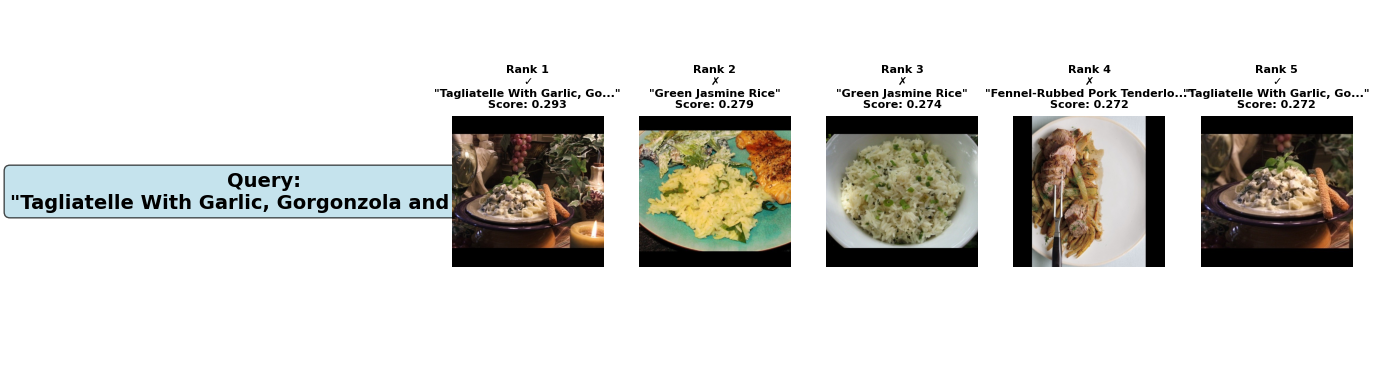

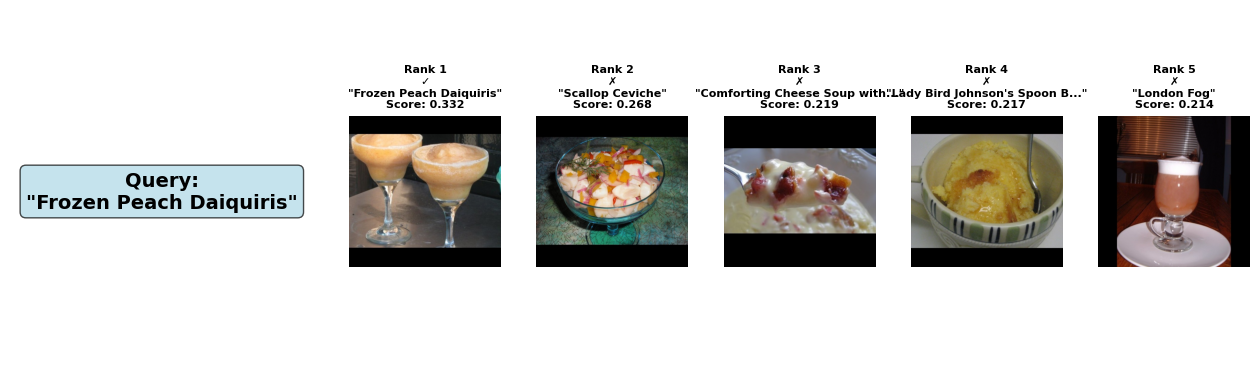

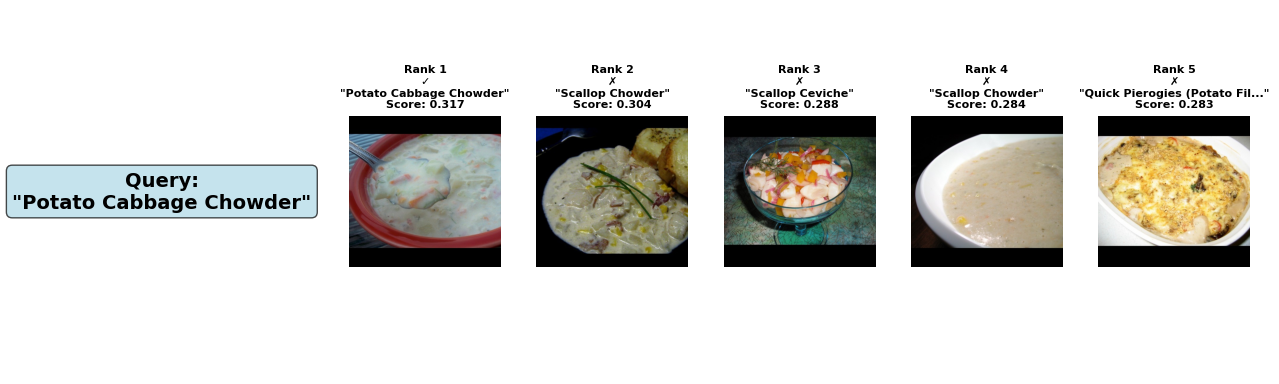


🖼️ Image → Text Retrieval (Top-5 captions for each image):


/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2195179363.py:97: RuntimeWarning: divide by zero encountered in matmul
  similarities = text_embeddings @ img_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2195179363.py:97: RuntimeWarning: overflow encountered in matmul
  similarities = text_embeddings @ img_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2195179363.py:97: RuntimeWarning: invalid value encountered in matmul
  similarities = text_embeddings @ img_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/2195179363.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


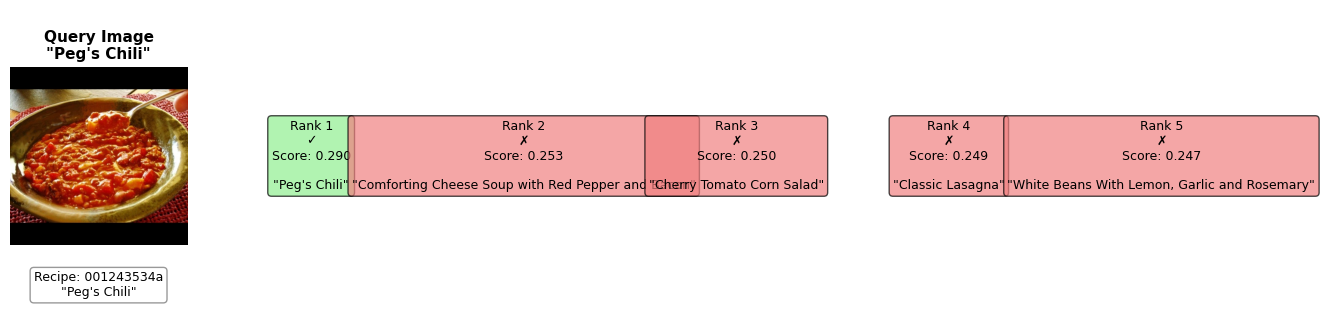

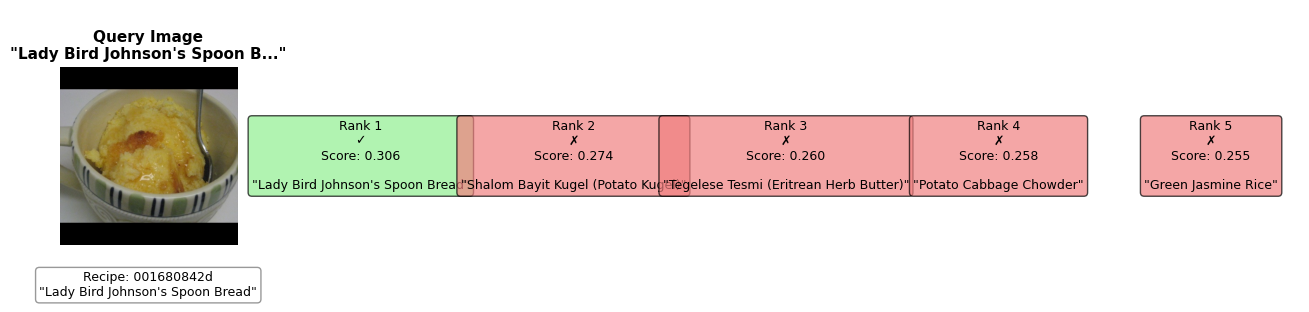

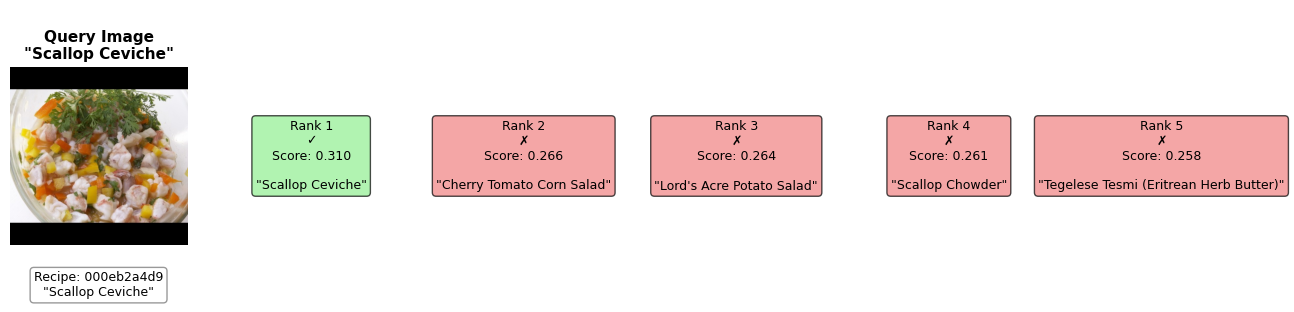

In [19]:
# Verify required variables exist (safety check)
assert "image_key_to_recipe_id" in globals(), "image_key_to_recipe_id not found. Run evaluation section first."
assert "text_embeddings" in globals(), "text_embeddings not found. Run evaluation section first."
assert "image_embeddings" in globals(), "image_embeddings not found. Run evaluation section first."
assert "unique_captions_list" in globals(), "unique_captions_list not found. Run evaluation section first."
assert "image_keys" in globals(), "image_keys not found. Run evaluation section first."

print("\n📝 Text → Image Retrieval (Top-5 images for each recipe):")
visualize_text_to_image_retrieval(
    test_df,
    text_embeddings_eval,
    image_embeddings_eval,
    recipe_to_caption_text,
    recipe_to_image_indices,
    caption_to_idx,
    image_keys,
    image_key_to_recipe_id,
    n_examples=3
)

print("\n🖼️ Image → Text Retrieval (Top-5 captions for each image):")
visualize_image_to_text_retrieval(
    test_df,
    text_embeddings_eval,
    image_embeddings_eval,
    recipe_to_all_caption_indices,
    image_key_to_idx,
    image_key_to_recipe_id,
    unique_captions_list,
    recipe_to_caption_text,
    n_examples=3
)


## 14. Generate Qualitative Examples


In [20]:
N_QUALITATIVE_EXAMPLES = CONFIG["evaluation"]["n_examples"]

def generate_top5_examples(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_caption_text: Dict[str, str],
    recipe_to_image_indices: Dict[str, List[int]],
    caption_to_idx: Dict[str, int],
    image_keys: List[str],
    image_key_to_recipe_id: Dict[str, str],
    n_examples: int = 5
) -> List[Dict]:
    """Generate qualitative examples showing top-5 retrievals by recipe_id."""
    examples = []
    valid_recipe_ids = []
    for recipe_id in test_df["recipe_id"].unique():
        recipe_id_str = str(recipe_id)
        caption = recipe_to_caption_text.get(recipe_id_str)
        if not caption:
            continue
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        gt_image_indices = recipe_to_image_indices.get(recipe_id_str, [])
        if len(gt_image_indices) > 0:
            valid_recipe_ids.append(recipe_id)
    
    if len(valid_recipe_ids) == 0:
        print("⚠ No valid recipes with ground truth images found")
        return examples
    
    sample_recipe_ids = pd.Series(valid_recipe_ids).sample(
        min(n_examples, len(valid_recipe_ids)),
        random_state=RANDOM_SEED
    )
    
    for recipe_id in sample_recipe_ids:
        recipe_id_str = str(recipe_id)
        caption = recipe_to_caption_text.get(recipe_id_str)
        if not caption:
            continue
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        gt_image_indices = set(recipe_to_image_indices.get(recipe_id_str, []))
        
        top5_images = []
        for i, idx in enumerate(top5_indices):
            img_key = image_keys[idx]
            img_recipe_id = image_key_to_recipe_id.get(img_key)
            is_correct = idx in gt_image_indices
            top5_images.append({
                "rank": i + 1,
                "image_key": img_key,
                "recipe_id": img_recipe_id,
                "similarity": float(similarities[idx]),
                "is_correct": is_correct
            })
        
        examples.append({
            "query_type": "text_to_image",
            "recipe_id": recipe_id_str,
            "query_caption": caption,
            "top5_images": top5_images
        })
    
    return examples

def generate_image_to_text_examples(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_all_caption_indices: Dict[str, List[int]],
    image_key_to_idx: Dict[str, int],
    image_key_to_recipe_id: Dict[str, str],
    unique_captions: List[str],
    n_examples: int = 5
) -> List[Dict]:
    """Generate qualitative examples for Image → Text retrieval."""
    examples = []
    unique_images = test_df["image_key"].dropna().astype(str).unique()
    sample_images = pd.Series(unique_images).sample(
        min(n_examples, len(unique_images)),
        random_state=RANDOM_SEED
    )
    
    for img_key in sample_images:
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        img_emb = image_embeddings[img_idx]
        similarities = text_embeddings @ img_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        recipe_id_str = image_key_to_recipe_id.get(img_key)
        gt_caption_indices = set(recipe_to_all_caption_indices.get(recipe_id_str, []))
        
        top5_captions = []
        for i, text_idx in enumerate(top5_indices):
            caption = unique_captions[text_idx]
            is_correct = text_idx in gt_caption_indices
            top5_captions.append({
                "rank": i + 1,
                "caption": caption,
                "similarity": float(similarities[text_idx]),
                "is_correct": is_correct
            })
        
        examples.append({
            "query_type": "image_to_text",
            "recipe_id": recipe_id_str,
            "query_image_key": img_key,
            "top5_captions": top5_captions
        })
    
    return examples

# Generate examples
assert "unique_captions_list" in globals(), "unique_captions_list not found"

text_to_image_examples = generate_top5_examples(
    test_df,
    text_embeddings_eval,
    image_embeddings_eval,
    recipe_to_caption_text,
    recipe_to_image_indices,
    caption_to_idx,
    image_keys,
    image_key_to_recipe_id,
    n_examples=N_QUALITATIVE_EXAMPLES
)

image_to_text_examples = generate_image_to_text_examples(
    test_df,
    text_embeddings_eval,
    image_embeddings_eval,
    recipe_to_all_caption_indices,
    image_key_to_idx,
    image_key_to_recipe_id,
    unique_captions_list,
    n_examples=N_QUALITATIVE_EXAMPLES
)

all_examples = text_to_image_examples + image_to_text_examples
print(f"✓ Generated {len(all_examples)} qualitative examples")


✓ Generated 10 qualitative examples


/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/3206760281.py:47: RuntimeWarning: divide by zero encountered in matmul
  similarities = image_embeddings @ text_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/3206760281.py:47: RuntimeWarning: overflow encountered in matmul
  similarities = image_embeddings @ text_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/3206760281.py:47: RuntimeWarning: invalid value encountered in matmul
  similarities = image_embeddings @ text_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/3206760281.py:96: RuntimeWarning: divide by zero encountered in matmul
  similarities = text_embeddings @ img_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/3206760281.py:96: RuntimeWarning: overflow encountered in matmul
  similarities = text_embeddings @ img_emb
/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/3206760281.py:96: RuntimeWarning: invalid value

## 15. Save Results


In [21]:
# Prepare results
results = {
    "run_id": RUN_ID,
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "model": MODEL_NAME,
    "method": "lora",
    "metrics": {
        "text_to_image": text_to_image_results,
        "image_to_text": image_to_text_results,
    },
    "metadata": {
        "device": DEVICE,
        "embedding_time_seconds": float(embedding_time),
        "filter_applied": "label == 1 (positive pairs only) for training",
    },
    "model_info": {
        "total_parameters": int(total_params),
        "trainable_parameters": int(trainable_params),
        "trainable_ratio": float(trainable_params / total_params),
    },
    "training_info": {
        "total_time_seconds": training_logs["total_time_seconds"],
        "peak_memory_mb": training_logs["peak_memory_mb"],
        "total_steps": training_logs["total_steps"],
        "num_epochs": TRAINING_CONFIG["num_epochs"],
        "final_loss": float(training_logs["epochs"][-1]["avg_loss"]) if training_logs["epochs"] else None,
    },
}

# Save results
print(f"Saving results to {RESULTS_KEY}...")
save_json_to_minio(results, FINE_TUNING_BUCKET, RESULTS_KEY)

# Save qualitative examples
print(f"Saving qualitative examples to {EXAMPLES_KEY}...")
save_json_to_minio({"examples": all_examples}, FINE_TUNING_BUCKET, EXAMPLES_KEY)

print("\n" + "=" * 60)
print("✓ All results saved successfully")
print("=" * 60)
print(f"Model: {MODEL_NAME} (LoRA fine-tuned)")
print(f"Run ID: {RUN_ID}")
print(f"\nResults saved to:")
print(f"  - {RESULTS_KEY}")
print(f"  - {EXAMPLES_KEY}")
print(f"  - {LOGS_KEY}")
print(f"  - {CONFIG_KEY}")
print(f"  - {ADAPTERS_DIR}/")


Saving results to experiments/baseline/run_baseline_20260103_190607/results_baseline.json...
Saving qualitative examples to experiments/baseline/run_baseline_20260103_190607/examples_top5.json...

✓ All results saved successfully
Model: openai/clip-vit-base-patch32 (LoRA fine-tuned)
Run ID: baseline_20260103_190607

Results saved to:
  - experiments/baseline/run_baseline_20260103_190607/results_baseline.json
  - experiments/baseline/run_baseline_20260103_190607/examples_top5.json
  - experiments/baseline/run_baseline_20260103_190607/training_logs.json
  - experiments/baseline/run_baseline_20260103_190607/config.yaml
  - experiments/baseline/run_baseline_20260103_190607/adapters/


/var/folders/7y/yp5p839x7qb78sgcn44jsqrhzvtrps/T/ipykernel_91197/1559337816.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",
